# Predicting Car Prices Using KNN
## Introduction to the Data Set
In this  project, I'll predict a car's market price using its attributes using machine learning workflow. The data set I will be working with contains information on various cars. For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. You can read more about the data set [here](https://archive.ics.uci.edu/dataset/10/automobile) and can download it directly from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data). 

## Reading the Data

In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# read and inspect the data
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('/Users/sumersener/Downloads/Datasets/imports-85.data.txt', names = cols)
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


Check if any of the columns has missing values.

In [2]:
# explore the dataset
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

As seen above, the dataset doesn't have any missing values. Examine the numeric columns above to determine the ones that could be useful for our analysis. Our target column is the `price` column. I have decided to keep only the continuous columns as potential features for my analysis. Names of the continuous columns can be found on the data sets [website](https://archive.ics.uci.edu/dataset/10/automobile). 

In [3]:
# extract the continuous cols
cts_cols = ['price', 'highway-mpg', 'city-mpg','peak-rpm','horsepower','compression-rate',
            'stroke', 'bore', 'engine-size', 'curb-weight', 'height', 'width', 'length', 
            'wheel-base' , 'normalized-losses']
cars = cars[cts_cols]

## Cleaning the Data
We usually can't have any missing values if we want to use them for predictive modeling. Based on the data set preview from the last step, we can tell that the `normalized-losses` column contains missing values represented using `"?"`. Let's replace these values and look for the presence of missing values in other numeric columns. Let's also rescale the values in the numeric columns so they all range from 0 to 1.

Start by replacing `?` values with `NaN` values.

In [4]:
# replace the question marks with NaN values
cars = cars.replace('?', np.nan)
cars.head()

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-rate,stroke,bore,engine-size,curb-weight,height,width,length,wheel-base,normalized-losses
0,13495,27,21,5000,111,9.0,2.68,3.47,130,2548,48.8,64.1,168.8,88.6,NaN
1,16500,27,21,5000,111,9.0,2.68,3.47,130,2548,48.8,64.1,168.8,88.6,NaN
2,16500,26,19,5000,154,9.0,3.47,2.68,152,2823,52.4,65.5,171.2,94.5,NaN
3,13950,30,24,5500,102,10.0,3.40,3.19,109,2337,54.3,66.2,176.6,99.8,164
4,17450,22,18,5500,115,8.0,3.40,3.19,136,2824,54.3,66.4,176.6,99.4,164


Because `'?'` is a string value, columns containing this value were cast to the pandas object data type (instead of a numeric type like `int` or `float`). After replacing `?` with `NaN` we can convert some of the `object` data type columns to numeric columns. Inspect the columns of `object` data type. 


Because `price` columns is what we want to predidict, let's remove any rows with null values in the `price` columns. Start by printing the number of null values in all columns of the dataset.


In [5]:
# convert all columns to numeric datatype.
cars = cars.astype(float)
cars.isnull().sum()

price                 4
highway-mpg           0
city-mpg              0
peak-rpm              2
horsepower            2
compression-rate      0
stroke                4
bore                  4
engine-size           0
curb-weight           0
height                0
width                 0
length                0
wheel-base            0
normalized-losses    41
dtype: int64

Remove any missing rows from the `price` column.

In [6]:
# remove the missing rows from the price col
cars.dropna(subset = ['price'], inplace = True)

Check again which columns have null values.

In [7]:
# total number of missing values in each column
cars.isnull().sum()

price                 0
highway-mpg           0
city-mpg              0
peak-rpm              2
horsepower            2
compression-rate      0
stroke                4
bore                  4
engine-size           0
curb-weight           0
height                0
width                 0
length                0
wheel-base            0
normalized-losses    37
dtype: int64

Replace all the missing values in the remaining columns using the column means. Because preserving the originality of data in the predictor columns is not as important as preserving the originality in the target column, we can replace the missing values in the predictor columns with the means.

In [8]:
# replace missing values in other cols using column means
cars = cars.fillna(cars.mean())

Check if there are any missing values remaining.

In [9]:
# total number of missing values in each column
cars.isnull().sum()

price                0
highway-mpg          0
city-mpg             0
peak-rpm             0
horsepower           0
compression-rate     0
stroke               0
bore                 0
engine-size          0
curb-weight          0
height               0
width                0
length               0
wheel-base           0
normalized-losses    0
dtype: int64

Based on the `Series` object above, the dataset doesn't have any other missing values in any of the columns.

Next, what we need to do is to normalize the predictor columns. I will use the min-max normalization method to achieve this. 

In [10]:
# use the min-max method to normalize all feature cols
price_col = cars['price']
cars = ((cars- cars.min())/(cars.max() - cars.min())) # normalize all cols
cars['price'] = price_col 

In this section we've cleaned the data by replacing `'?'` with `NaN` values. We then replaced the missing values in all of the columns with the mean value of that column. Finally, we normalized the feature columns using the min-max normalization technique.

## Univariate Model
Let's start with some univariate k-nearest neighbors models.<br>
In this section we are going to write a functoin that returns the rmse after training the knn model on a single column only. We will then rank these individucal columns by their rmse values to find the ones with smallest prediction errors.

In [11]:
# define the function
def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
    random_index = np.random.permutation(df.index) # randomise the rows in the df using permutations
    df = df.reindex(random_index)
    n_rows = len(df)
    len_train = int(0.8*n_rows) # 80% percent of the original data should be used to train the model
    train_set = df.iloc[:len_train]
    test_set = df.drop(train_set.index) # remaining rows belong to the test set
    
    knn = KNeighborsRegressor() 
    knn.fit(train_set[[train_col]], train_set[target_col]) # fit the model
    predictions = knn.predict(test_set[[train_col]]) # predict using the test data
    mse = mean_squared_error(test_set[target_col], predictions)
    rmse = np.sqrt(mse)
    return rmse


Test the function above by training and testing univariate models on different columns of the data. The goal is to find which column performes the best with the default `k` value of 5 of this model.

In the next cell, create a dictionary where the column names are the keys and the correponding rmse values are the values. 

In [12]:
# create a rmse dictionary
cols_rmses = dict() # intialise empty dict
for col in cars.columns:
    cols_rmses[col] = knn_train_test(col, 'price', cars)
    
cols_rmses.pop('price') # remove the price col because it is not a feature 
rmse_df = pd.DataFrame(list(cols_rmses.items()), columns = ['Feature', 'rmse']) # create a df from the dictionary above


Next, sort the column names in the `cols_rmses` dictionary by their corresponding rmse values.

In [13]:
# sort the col names
rmse_df.sort_values(by = 'rmse')

,Feature,rmse
7,engine-size,3316.053426
8,curb-weight,3540.864697
0,highway-mpg,3926.839057
1,city-mpg,4058.968938
10,width,4466.892222
12,wheel-base,4676.644160
3,horsepower,4976.488480
11,length,5734.415009
13,normalized-losses,6524.223795
4,compression-rate,6566.863205


## Univariate Model 2.0
Modify the knn_train_test() function to accept a parameter for the k value, where k is the number of nearest neighbours we are considering for the model.<br>
Update the function logic to use this parameter.<br>
For each numeric column, create, train, and test a univariate model using the following k values (1, 3, 5, 7, and 9). Visualize the results using a scatter plot or a line plot.


In [14]:
# define the function
def knn_train_test_2(train_col, target_col, df, k):
    np.random.seed(1)
    random_index = np.random.permutation(df.index) # randomise the rows in the df using permutations
    df = df.reindex(random_index)
    n_rows = len(df)
    len_train = int(0.8*n_rows) # 80% percent of the original data should be used to train the model
    train_set = df.iloc[:len_train]
    test_set = df.drop(train_set.index) # remaining rows belong to the test set
    rmse_dict = dict()
    
    
    knn = KNeighborsRegressor( n_neighbors = k) 
    knn.fit(train_set[[train_col]], train_set[target_col]) # fit the model
    predictions = knn.predict(test_set[[train_col]]) # predict using the test data
    mse = mean_squared_error(test_set[target_col], predictions)
    rmse = np.sqrt(mse)
    return rmse

Having updated the function as `knn_train_test_2`, check if the function is working.

In [15]:
# test to see if the function is working
knn_train_test_2('horsepower', 'price',cars,  k =7)

5010.75579321259

Extract the columns that aren't the `price` columns from our `cars` dataset. Print the names of these columns to check that they are the right set of columns.


In [16]:
# extract the columns that aren't the price column
feature_cols = list(cars.columns)
feature_cols.remove('price') # extract the cols in cars that aren't the price column
print(feature_cols)

['highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower', 'compression-rate', 'stroke', 'bore', 'engine-size', 'curb-weight', 'height', 'width', 'length', 'wheel-base', 'normalized-losses']


Iterate over these columns with a nested loop to compute the rmse for these columns for different values of the hyperparameter `n_neighbors`. This loop is going to give us the rmse score for all combinations of predictor columns and number of neighbours in [1,3,5,7,9].

In [17]:
# iterate over the cols and number of neighbours with a nested loop
rmse_results_by_col = dict() # this dict will have train_col name as the key and the corresponding ditionary of rmses values as the value

for col in feature_cols:
    rmse_per_k = dict()
    for k in [1,3,5,7,9]:
        rmse_per_k[k] = knn_train_test_2(col, 'price', cars, k)
    rmse_results_by_col[col] = rmse_per_k
        

Next, inspect the dictionary to see if it is created correctly.

In [18]:
# inspect the dictionary
rmse_results_by_col

{'highway-mpg': {1: 3853.495995877497,
  3: 3948.5827054924184,
  5: 3926.839056618614,
  7: 4458.67366680923,
  9: 4442.054367713342},
 'city-mpg': {1: 4613.52236736166,
  3: 3480.041017731666,
  5: 4058.9689382836154,
  7: 4143.78948472029,
  9: 4494.777492224397},
 'peak-rpm': {1: 8715.520870767305,
  3: 8248.813770019671,
  5: 7703.375030560527,
  7: 7353.35312664074,
  9: 7563.140333585672},
 'horsepower': {1: 3725.6608515118237,
  3: 4622.9228732046695,
  5: 4976.488479572426,
  7: 5010.75579321259,
  9: 5011.5681614557125},
 'compression-rate': {1: 7119.430526691741,
  3: 6015.266262942326,
  5: 6566.863204924793,
  7: 6190.709533134599,
  9: 6415.837289775735},
 'stroke': {1: 7650.660094269564,
  3: 7463.69391969079,
  5: 6886.320496285442,
  7: 6994.464523936432,
  9: 7276.2123808311535},
 'bore': {1: 5819.333833721234,
  3: 6358.352465527589,
  5: 7346.6164918977765,
  7: 7570.11827298613,
  9: 7431.3295664749385},
 'engine-size': {1: 3960.164316620479,
  3: 3500.398733384945

The dictionary above was what we aimed for. It shows each predictor column name and what value of rmse was obtained using that column and the corresponding number of neighbours.

### Ranking the Columns and Plotting 
I ranked the columns by their rmse values and find the columns with the smallest average rmse values. <br>
Then plotted the rmse for different columns for varying k values. 



In [19]:
# find the cols with the smallest average rmse values
rmse_mean_by_col = dict()
for col,results in rmse_results_by_col.items():
    mean_rmse = np.mean(list(results.values()))
    rmse_mean_by_col[col] = mean_rmse
    
col_mean_df = pd.DataFrame(list(rmse_mean_by_col.items()), columns = ['Feature', 'Mean RMSE'])
col_mean_df = col_mean_df.sort_values(by = 'Mean RMSE').reset_index(drop = True)
col_mean_df # dataframe of features versus the mean rmse for that feature

,Feature,Mean RMSE
0,engine-size,3445.431053
1,curb-weight,3824.233453
2,highway-mpg,4125.929159
3,city-mpg,4158.219860
4,width,4192.221747
5,wheel-base,4272.420465
6,horsepower,4669.479232
7,length,5340.464772
8,compression-rate,6461.621363
9,bore,6905.150126


Having computed the mean rmse value for all of the predictor columns, we want to plot these columns on the same axis to see if the graph created matches with the table above.

Text(0, 0.5, 'RMSE')

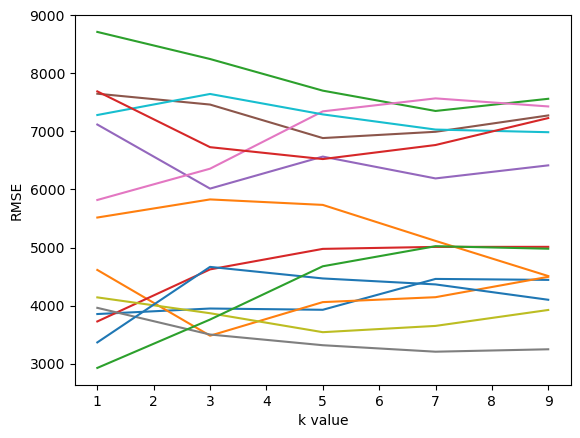

In [20]:
# line plot visualisation
for k, v in rmse_results_by_col.items():
    keys = sorted(list(v.keys()))
    values = list(v.values())
    plt.plot(keys,values, label = k)
    
plt.xlabel('k value')
plt.ylabel('RMSE')


The line plot shows that the columns corresponding to the lower lines are much better predictors for the `price` columns that the ones further up in the plot.

## Multivariate Model
Modify the `knn_train_test()` function to accept a list of column names (instead of just a string). Modify the rest of the function logic to use this parameter.<br>
Instead of using just a single column for train and test, use all of the columns passed in.<br>
Use a the default k value from scikit-learn for now (we'll tune the k value later on).

After modifying the function use the best i features(where i is in [2,3,4,5]) from the previous section to train and test a multivariate k-nearest neighbous model using the default k = 5 value. 

In [21]:
# define the function
def knn_multivariate(train_cols, target_col, df):
    np.random.seed(1) # for the results to be repeat
    random_index = np.random.permutation(df.index) # randomise the rows in the df using permutations
    df = df.reindex(random_index)
    n_rows = len(df)
    len_train = int(0.8*n_rows) # 80% percent of the original data should be used to train the model
    train_set = df.iloc[:len_train]
    test_set = df.drop(train_set.index) # remaining rows belong to the test set
    
    knn = KNeighborsRegressor() 
    knn.fit(train_set[train_cols], train_set[target_col]) # fit the model
    predictions = knn.predict(test_set[train_cols]) # predict using the test data
    mse = mean_squared_error(test_set[target_col], predictions)
    rmse = np.sqrt(mse)
    return rmse


Extract the 6 predictor columns with the highest mean rmse.

In [22]:
list(col_mean_df['Feature'].iloc[:6])

['engine-size',
 'curb-weight',
 'highway-mpg',
 'city-mpg',
 'width',
 'wheel-base']

Next, calculate the rmse value for the best i columns where i takes all the integer values between 2-6. 

In [23]:
for i in range(2,7):
    train_cols = list(col_mean_df['Feature'].iloc[:i]) # train the model using the best i features with lowest rmse values
    print('RMSE value for the best {} columns is: {}'.format(i,knn_multivariate(train_cols, 'price', cars)))

RMSE value for the best 2 columns is: 2763.6785655460258
RMSE value for the best 3 columns is: 2870.7875023941497
RMSE value for the best 4 columns is: 2855.8087824557197
RMSE value for the best 5 columns is: 2736.7699471118567
RMSE value for the best 6 columns is: 2712.2406050186983


## Hyperparameter Tuning
Let's now optimize the model that performed the best in the previous step.<br>
For the top 3 models in the last step, vary the hyperparameter value from 1 to 25 and plot the resulting RMSE values.<br>
Top three models found in the last section corresponded to considering the best 2,3 and 4 columns. <br>
In this section only focus on those three models and try to find the optimum number of nearest neighbors to consider to minimise the root mean squared error.<br>
I have updated the multivariate version of our function below to accept another parameter k as the number of neighbors we're considering. 

In [24]:
# define the function
def knn_multivariate_2(train_cols, target_col, df, k):
    np.random.seed(1) # for the results to be repeatable
    random_index = np.random.permutation(df.index) # randomise the rows in the df using permutations
    df = df.reindex(random_index)
    n_rows = len(df)
    len_train = int(0.8*n_rows) # 80% percent of the original data should be used to train the model
    train_set = df.iloc[:len_train]
    test_set = df.drop(train_set.index) # remaining rows belong to the test set
    
    knn = KNeighborsRegressor(k) 
    knn.fit(train_set[train_cols], train_set[target_col]) # fit the model
    predictions = knn.predict(test_set[train_cols]) # predict using the test data
    mse = mean_squared_error(test_set[target_col], predictions)
    rmse = np.sqrt(mse)
    return rmse


Next, test the updated version of the function to see if it is working.

In [25]:
# test the function
knn_multivariate_2(list(col_mean_df['Feature'].iloc[:3]), 'price', cars, 7)

2872.727369950154

Next, create a list of the top 3 best performing models based on the dictionary `train_cols` that was created at the end of the last section.

In [30]:
# create a list of the top 3 best performing models
top_3 = [list(col_mean_df['Feature'].iloc[:2]), 
             list(col_mean_df['Feature'].iloc[:3]),
         list(col_mean_df['Feature'].iloc[:4])]
for i in top_3:
    print(i)

['engine-size', 'curb-weight']
['engine-size', 'curb-weight', 'highway-mpg']
['engine-size', 'curb-weight', 'highway-mpg', 'city-mpg']


Next, create a dictionary that holds the RMSE values for the top 3 models we've identified in the above cell. Compute the RMSE values for these three models for hyperparameter ranging between 1-25, both ends inclusive.

In [31]:
# create a dict of the models and their corresponding RMSE values
model_hyp_rmse = dict()
for cols in top_3:
    hyp_rmse = dict()
    
    for hyp in range(1,26):
        hyp_rmse[hyp] = knn_multivariate_2(cols, 'price', cars, hyp)
    model_hyp_rmse['best {} features'.format(len(cols))] = hyp_rmse

Inspect the dictionary to see if it was created correctly.

In [32]:
# inspect the dictionary
model_hyp_rmse

{'best 2 features': {1: 2902.6830985713386,
  2: 3041.9159028079816,
  3: 2821.2597236313213,
  4: 2794.9068672035323,
  5: 2763.6785655460258,
  6: 2712.6988194091596,
  7: 2664.1783809451035,
  8: 2677.3165646639136,
  9: 2724.106645703047,
  10: 2780.493867695572,
  11: 2870.536763116885,
  12: 2868.946310923115,
  13: 3068.3771632230473,
  14: 3183.164577875407,
  15: 3345.908124721686,
  16: 3503.6666483357203,
  17: 3652.7939268371765,
  18: 3686.5128264877203,
  19: 3628.5329077229294,
  20: 3654.0762917396323,
  21: 3720.670422050967,
  22: 3785.9979528976096,
  23: 3849.0651286345455,
  24: 3885.4262153046425,
  25: 3951.881918088782},
 'best 3 features': {1: 2523.382737323926,
  2: 2728.1490039594387,
  3: 2654.1997916274763,
  4: 2645.4524749569964,
  5: 2870.7875023941497,
  6: 2890.4515664736678,
  7: 2872.727369950154,
  8: 3009.2856084284376,
  9: 3047.3520522845865,
  10: 3044.549767627551,
  11: 3304.492476693278,
  12: 3352.660643213109,
  13: 3444.7711994678984,
  14

Create a line plot to see how the best three models are performing with different numbers of neighbours.

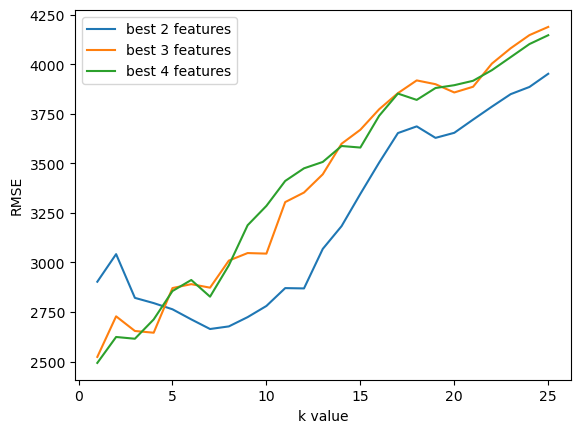

In [33]:
# line plot visualisation
for k, v in model_hyp_rmse.items():
    keys = sorted(list(v.keys()))
    values = list(v.values())
    plt.plot(keys,values, label = k)
    
plt.xlabel('k value')
plt.ylabel('RMSE')
plt.legend(loc = 'upper left')

Above line plot suggestss that for lower values of the hyperparameter, the model with 2 predictor columns performs worse. However, as soon as the hypereparameter exceeds 5, the model with 2 predictors has a lower RMSE value than the other two. Because we want to minimise the RMSE of the model, the best multivariate model would be the one with 4 predictor columns and a number of hyperparameter lower than 5. Judging by the graph above, a model with 4 predictor columns and 3 nearest neighbours seems like a good option. Lower number of nearest neighbours might not be able to capture the complexity of the dataset.

## Conclusion
Summary of the steps I took in this project:
1. Cleaned the data.
2. Trained two univariate k nearest neighbors models and experimented with different numbers of neighbors. I then used the data obtained from our univariate model to determine which columns to feed into our multivariate model.
3. Trained two multivariate models and used hyperparameter tuning to find the optimal number of neighbors to consider. I suggested that to minimise the RMSE we should consider a model with hyperparameter value of 3 and top 4 predictor columns as the predictor columns in the KNN model.